# Task 1: Price Prediction

## Performing imports and reading the data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

external_df = pd.read_csv('/Users/arielguerra/Downloads/data-3/timeseries/2015/external.csv')
global_df = pd.read_csv('/Users/arielguerra/Downloads/data-3/timeseries/2015/global.csv')
by_actor_df = pd.read_csv('/Users/arielguerra/Downloads/data-3/timeseries/2015/by_actor.csv')

external_df.sort_values(by=['week', 'weekday'], inplace=True)
global_df.sort_values(by=['week', 'weekday'], inplace=True)
by_actor_df.sort_values(by=['week', 'weekday'], inplace=True)

### Based on previous correlation analysis, we will use the following features:

In [ ]:
by_actor_agg = by_actor_df.groupby(['week', 'weekday']).sum()[['received', 'spent']]

# Merging the datasets
merged_df = external_df.merge(global_df[['week', 'weekday', 'nb_transactions', 'total_sent_satoshi', 'mean_feeUSD']], on=['week', 'weekday'], how='left')
merged_df = merged_df.merge(by_actor_agg, on=['week', 'weekday'], how='left')

# Creating lagged features for PriceUSD
for lag in range(1, 6):
    merged_df[f'PriceUSD_lag_{lag}'] = merged_df['PriceUSD'].shift(lag)

# Target Variable: PriceUSD of the next day
merged_df['PriceUSD_next_day'] = merged_df['PriceUSD'].shift(-1)

# Dropping rows with NaN values (due to lagged features and next day Price)
merged_df.dropna(inplace=True)

# Separating the features and target variable
X = merged_df.drop(['PriceUSD', 'PriceUSD_next_day'], axis=1)
y = merged_df['PriceUSD_next_day']

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print column names in X_train
print(X_train.columns)

# Print the name of the target variable in y_train
print(y_train.name)
# Fitting a Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

# Making predictions and evaluating the model
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

### Running it on the train data to see how it performs

In [ ]:
import matplotlib.pyplot as plt

def predict_seventh_day_price(model, data):
    predictions = []
    actual_values = []
    weeks = data['week'].unique()

    for week in weeks:
        week_data = data[data['week'] == week]
        if week_data.shape[0] >= 6:
            X_week = week_data.iloc[:6].drop(['PriceUSD', 'PriceUSD_next_day'], axis=1)
            prediction = model.predict([X_week.iloc[-1]])[0]
            actual_value = week_data.iloc[6]['PriceUSD'] if week_data.shape[0] > 6 else np.nan
            predictions.append(prediction)
            actual_values.append(actual_value)

    return predictions, actual_values

predicted_prices, actual_prices = predict_seventh_day_price(regressor, merged_df)

plt.figure(figsize=(15, 6))
plt.plot(predicted_prices, label='Predicted Prices', color='blue')
plt.plot(actual_prices, label='Actual Prices', color='orange')
plt.xlabel('7th days')
plt.ylabel('Price (USD)')
plt.title('Predicted vs Actual Bitcoin Prices of Every 7th Day')
plt.legend()
plt.show()

## Franck's ARIMA

In [4]:

# Chemins vers les fichiers CSV
external_data_path = 'drive/MyDrive/data/timeseries/task1/external.csv'
global_data_path = 'drive/MyDrive/data/timeseries/task1/global.csv'
by_actor_data_path = 'drive/MyDrive/data/timeseries/task1/by_actor.csv'

# Lecture des fichiers CSV
task_external_data = pd.read_csv(external_data_path)
task_global_data = pd.read_csv(global_data_path)
task_by_actor_data = pd.read_csv(by_actor_data_path)

# Calcul des matrices de corrélation
task_corr_external = task_external_data.corr()
task_corr_global = task_global_data.corr()
task_corr_by_actor = task_by_actor_data.corr()
#on combine la data pour le task
task_combined_data = pd.merge(task_external_data, task_global_data, on=['week', 'weekday'])
task_combined_data = pd.merge(task_combined_data, task_by_actor_data, on=['week', 'weekday'])

<ipython-input-4-745989349812>:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  task_corr_global = task_global_data.corr()
<ipython-input-4-745989349812>:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  task_corr_by_actor = task_by_actor_data.corr()


In [5]:
# Affichage des premières lignes du fichier combiné
#print(task_combined_data.head())
task_corr_combined = task_combined_data.corr()
"""
# Affichage des matrices de corrélation avec des heatmaps
plt.figure(figsize=(18, 6))

sns.heatmap(corr_combined, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for external.csv')"""
threshold = 0.2
task_significant_columns = task_corr_combined[abs(task_corr_combined['PriceUSD']) > threshold].index.tolist()
#meme si ils sont pas relevant on va les gardé car colonnes importante
if 'weekday' not in task_significant_columns:
    task_significant_columns.append('weekday')
if 'week' not in task_significant_columns:
    task_significant_columns.append('week')

# Filtrage du dataset combiné pour ne garder que les colonnes significativement corrélées avec 'PriceUSD'
task_filtered_combined_data = task_combined_data[task_significant_columns]

# Affichage des premières lignes du dataset filtré
#print(task_filtered_combined_data.head())
"""
# Affichage de la heatmap de la matrice de corrélation pour le dataset filtré
plt.figure(figsize=(18, 6))
sns.heatmap(task_filtered_combined_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Filtered Combined Data')
plt.show()
"""

<ipython-input-5-4c57bd713738>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  task_corr_combined = task_combined_data.corr()


"\n# Affichage de la heatmap de la matrice de corrélation pour le dataset filtré\nplt.figure(figsize=(18, 6))\nsns.heatmap(task_filtered_combined_data.corr(), annot=True, cmap='coolwarm')\nplt.title('Correlation Heatmap for Filtered Combined Data')\nplt.show()\n"

In [6]:
# regroupement des données par 'week' et weekday et calcul de la moyenne pour les autres colonnes
task_final_data = task_filtered_combined_data.groupby(['week','weekday']).mean()

# on les gardes dans la data frame
task_final_data.reset_index(inplace=True)
# Calcul de la différence de 'PriceUSD' par rapport au jour précédent
task_final_data['variation'] = task_final_data['PriceUSD'].diff()

# Application d'une fonction pour convertir la différence en 1 ou -1
task_final_data['variation'] = task_final_data['variation'].apply(lambda x: 1 if x > 0 else -1)
# Affichage des premières lignes pour vérifier
print(task_final_data.head(10))
print(task_final_data.columns)

   week  weekday     PriceUSD      HashRate     total_fee  mean_fee_satoshi  \
0     1        0   407.990154  1.257201e+06  5.190514e+09      24772.648721   
1     1        1   397.314454  1.181319e+06  6.182855e+09      26570.641741   
2     1        2   403.705187  1.165568e+06  3.935633e+09      24009.471962   
3     1        3   413.229366  1.047436e+06  4.422026e+09      23947.111704   
4     1        4   411.425953  1.212821e+06  4.463445e+09      22473.417174   
5     1        5   412.540704  1.323077e+06  5.437813e+09      28611.331830   
6     2        0  1015.302039  2.910612e+06  1.625655e+10      50775.700984   
7     2        1  1033.785973  2.824556e+06  1.377181e+10      47860.840408   
8     2        2  1014.567876  3.336808e+06  1.389524e+10      47123.592726   
9     2        3  1023.317481  2.623277e+06  1.531078e+10      66642.802624   

    mean_feeUSD  mean_fee_for100_x  nb_transactions_x  nb_payments  \
0  1.010700e+07           0.819482           209526.0     54

In [39]:
import numpy as np
# Initialisation des listes pour les données d'entraînement et de test
y_train = []
y_test = []
task_train=[]
# Obtention des numéros de semaine uniques
unique_weeks = final_data['week'].unique()

for week in unique_weeks:
    # Sélection des données de la semaine courante
    weekly_data = final_data[final_data['week'] == week]

    # Vérification s'il y a des données complètes pour la semaine (6 jours pour l'entraînement, 1 jour pour le test)
    if len(weekly_data) == 7:
        # Séparation des données des 6 premiers jours et du 7ème jour
        train_data_week = weekly_data[weekly_data['weekday'] < 6]
        test_data_week = weekly_data[weekly_data['weekday'] == 6]
        y_train.append(train_data_week['PriceUSD'])
        y_test.append(test_data_week['PriceUSD'])
y_train = np.array(y_train)
y_test = np.array(y_test)
# Obtention des numéros de semaine uniques
unique_weeks = final_data['week'].unique()

task_unique_weeks = task_final_data['week'].unique()

for week in task_unique_weeks:
    # Sélection des données de la semaine courante
    weekly_data = task_final_data[task_final_data['week'] == week]

    # Vérification s'il y a des données complètes pour la semaine (6 jours pour l'entraînement, 1 jour pour le test)
    # Séparation des données des 6 premiers jours et du 7ème jour
    train_data_week = weekly_data[weekly_data['weekday'] < 6]
    task_train.append(train_data_week['PriceUSD'])
task_train=np.array(task_train)
# Obtention des numéros de semaine uniques
unique_weeks = final_data['week'].unique()

In [46]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Concaténation de toutes les séries temporelles d'entraînement en une seule
all_train_data = np.concatenate(y_train)

# Entraînement du modèle ARIMA sur l'ensemble des données d'entraînement
model = ARIMA(all_train_data, order=(5, 1, 1))
model_fit = model.fit()

# Prédictions pour chaque semaine
predictions_2015 = []
actual_values_2015 = []

# Index de départ pour la prédiction dans les données d'entraînement
start_index = 0

for i in range(len(y_train)):
    # Longueur des données pour cette semaine
    len_week_data = len(y_train[i])

    # Prédiction pour la semaine suivante
    end_index = start_index + len_week_data
    prediction = model_fit.predict(start=start_index, end=end_index-1)[-1]
    predictions_2015.append(prediction)

    # Valeur réelle pour le 7ème jour
    actual_value = y_test[i][0]
    actual_values_2015.append(actual_value)

    # Mise à jour de l'index de départ pour la prochaine itération
    start_index += len_week_data

# Conversion en arrays numpy pour l'évaluation
predictions_2015 = np.array(predictions_2015)
actual_values_2015 = np.array(actual_values_2015)

# Calcul des métriques d'évaluation
mse_2015 = mean_squared_error(actual_values_2015, predictions_2015)
r2_2015 = r2_score(actual_values_2015, predictions_2015)


In [47]:
print(mse_2015)
print(r2_2015)

116.39272718816025
0.9688216202762233


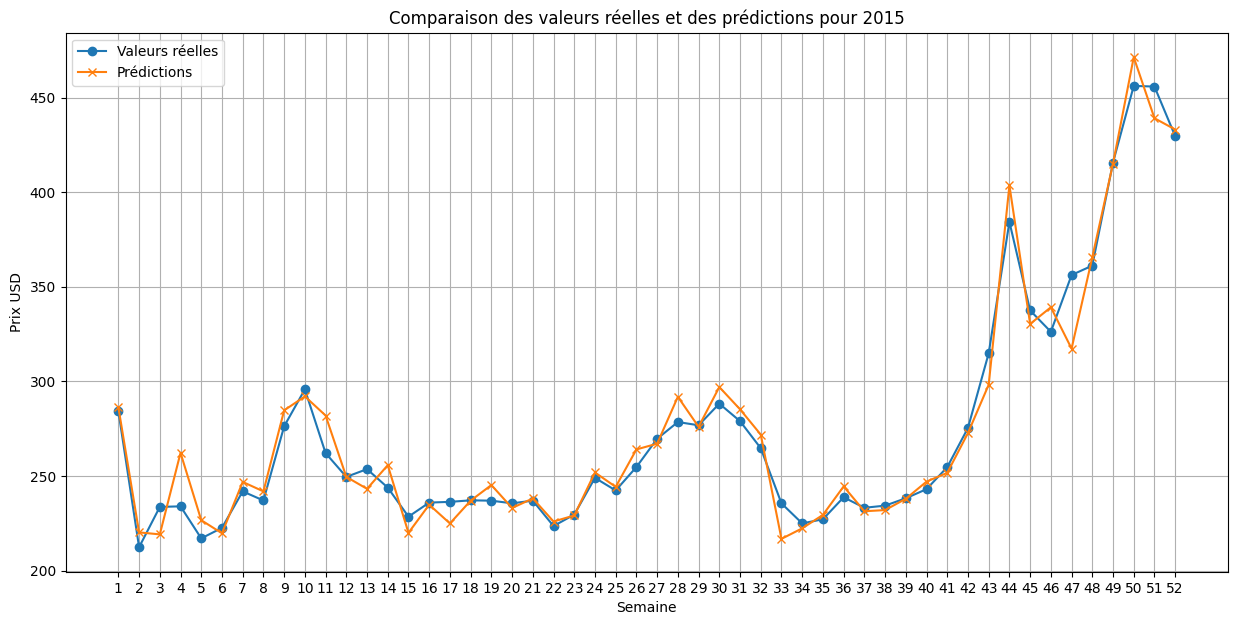

In [48]:
import matplotlib.pyplot as plt

# Définition de la taille du graphique
plt.figure(figsize=(15, 7))

# Création de l'axe des x pour le nombre de semaines
weeks = np.arange(1, len(actual_values_2015) + 1)

# Tracé des valeurs réelles
plt.plot(weeks, actual_values_2015, label='Valeurs réelles', marker='o')

# Tracé des prédictions
plt.plot(weeks, predictions_2015, label='Prédictions', marker='x')

# Ajout des titres et labels
plt.title('Comparaison des valeurs réelles et des prédictions pour 2015')
plt.xlabel('Semaine')
plt.ylabel('Prix USD')
plt.xticks(weeks)  # Assurez-vous que les semaines sont bien affichées sur l'axe des x

# Ajout de la légende
plt.legend()

# Affichage du graphique
plt.grid(True)
plt.show()

In [12]:
# Liste pour stocker les prédictions pour 2016
predictions_2016 = []

# Boucle sur les données de 2016
for weekly_data in task_train:
    # Mise à jour du modèle avec les données de la semaine spécifique de 2016
    #print(weekly_data)
    updated_model = model_fit.apply(weekly_data)
    prediction = updated_model.forecast()[0]
    #print(prediction)
    predictions_2016.append(prediction)

# Affichage des prédictions pour 2016
for i, pred in enumerate(predictions_2016):
    print(f"Prédiction pour la semaine {i+1} de 2016: {pred}")

Prédiction pour la semaine 1 de 2016: 411.1946666339399
Prédiction pour la semaine 2 de 2016: 1052.7735185982401
Prédiction pour la semaine 3 de 2016: 2653.185277437634
Prédiction pour la semaine 4 de 2016: 570.6608914532491
Prédiction pour la semaine 5 de 2016: 547.622495981373
Prédiction pour la semaine 6 de 2016: 428.7508225597762
Prédiction pour la semaine 7 de 2016: 454.88637718678
Prédiction pour la semaine 8 de 2016: 654.3546638474033
Prédiction pour la semaine 9 de 2016: 395.79723094152774
Prédiction pour la semaine 10 de 2016: 1013.1895152080875
Prédiction pour la semaine 11 de 2016: 446.5711036095099
Prédiction pour la semaine 12 de 2016: 442.3628319552739
Prédiction pour la semaine 13 de 2016: 609.33619851305
Prédiction pour la semaine 14 de 2016: 604.8866034977048
Prédiction pour la semaine 15 de 2016: 787.1215240351828
Prédiction pour la semaine 16 de 2016: 777.4728968510051
Prédiction pour la semaine 17 de 2016: 657.4486573600237
Prédiction pour la semaine 18 de 2016: 377

# reunion des données

#Prediction avec Arima

In [16]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np


# Assurez-vous que les données sont triées par 'week' et 'weekday'
final_data.sort_values(by=['week', 'weekday'], inplace=True)
task_final_data.sort_values(by=['week', 'weekday'], inplace=True)

# Entraînement du modèle ARIMA sur les données de 2015
model_2015 = ARIMA(final_data['PriceUSD'], order=(5, 1, 1))
model_fit_2015 = model_2015.fit()

# Prédictions pour 2016
predictions_2016 = []

for week in task_final_data['week'].unique():
    weekly_data_2016 = task_final_data[task_final_data['week'] == week]

    if len(weekly_data_2016) == 6:
        # Update the model with data for this specific week in 2016
        updated_model = model_fit_2015.apply(weekly_data_2016['PriceUSD'])
        # Faire la prédiction pour le 7ème jour
        prediction = updated_model.forecast().iloc[-1]
        #print(weekly_data_2016['PriceUSD'])
        predictions_2016.append(prediction)
        #print(predictions_2016)

# Afficher les prédictions
for i, pred in enumerate(predictions_2016):
    print(f"Semaine {task_final_data['week'].unique()[i]}, Prédiction pour le 7ème jour: {pred}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Semaine 1, Prédiction pour le 7ème jour: 412.86809261676126
Semaine 2, Prédiction pour le 7ème jour: 1049.659787731956
Semaine 3, Prédiction pour le 7ème jour: 2631.36965009007
Semaine 4, Prédiction pour le 7ème jour: 570.9815631758853
Semaine 5, Prédiction pour le 7ème jour: 542.5697888773955
Semaine 6, Prédiction pour le 7ème jour: 428.1889340995765
Semaine 7, Prédiction pour le 7ème jour: 456.151637206999
Semaine 8, Prédiction pour le 7ème jour: 653.832270523427
Semaine 9, Prédiction pour le 7ème jour: 394.08770071040055
Semaine 10, Prédiction pour le 7ème jour: 1015.2645547302942
Semaine 11, Prédiction pour le 7ème jour: 445.81333337256416
Semaine 12, Prédiction pour le 7ème jour: 441.8419150230515
Semaine 13, Prédiction pour le 7ème jour: 609.6376746601619
Semaine 14, Prédiction pour le 7ème jour: 605.462102720672
Semaine 15, Prédiction pour le 7ème jour: 781.4534388067078
Semaine 16, Prédiction pour le 7ème jour: 777.7324542080164
Semaine 17, Prédiction pour le 7ème jour: 656.303

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Ordre 5

Ici le but ca etre de séparé les données en séquence, comme ceci :              X train :  [[week1],[week2],..] où à l'intérieur de week1 les données seront comme ceci :[jour1,jour2,...,jour6], quant a y il contiendra les valeurs des prix en btc de ses séquences ensuite on va avoir x_test qui contiendra seulement les données des 7 eme jour


In [35]:
print(final_data.columns)
print(task_final_data.columns)

Index(['week', 'weekday', 'month_x', 'PriceUSD', 'HashRate', 'month_y',
       'total_fee', 'total_received_satoshi', 'total_sent_satoshi',
       'mean_feeUSD', 'nb_transactions_x', 'nb_payments', 'nb_mining',
       'total_mining_satoshi', 'newly_created_coins', 'self_spent_satoshi',
       'total_received', 'volume_without_self', 'original order', 'month',
       'day', 'variation'],
      dtype='object')
Index(['week', 'weekday', 'PriceUSD', 'HashRate', 'total_fee',
       'mean_fee_satoshi', 'mean_feeUSD', 'mean_fee_for100_x',
       'nb_transactions_x', 'nb_payments', 'mean_nb_outputs',
       'total_mining_satoshi', 'newly_created_coins', 'original order',
       'variation'],
      dtype='object')


In [16]:
# Initialisation des listes pour les données d'entraînement et de test
X_train = []
y_train = []
X_test = []
y_test = []
task_train=[]
# Obtention des numéros de semaine uniques
unique_weeks = final_data['week'].unique()

for week in unique_weeks:
    # Sélection des données de la semaine courante
    weekly_data = final_data[final_data['week'] == week]

    # Vérification s'il y a des données complètes pour la semaine (6 jours pour l'entraînement, 1 jour pour le test)
    if len(weekly_data) == 7:
        # Séparation des données des 6 premiers jours et du 7ème jour
        train_data_week = weekly_data[weekly_data['weekday'] < 6]
        test_data_week = weekly_data[weekly_data['weekday'] == 6]

        # Ajout des données des 6 jours à X_train et des prix correspondants à y_train
        X_train.append(train_data_week.drop(['PriceUSD', 'week', 'weekday'], axis=1))
        y_train.append(train_data_week['PriceUSD'])

        # Ajout des données du 7ème jour à X_test et du prix correspondant à y_test
        X_test.append(test_data_week.drop(['PriceUSD', 'week', 'weekday'], axis=1))
        y_test.append(test_data_week['PriceUSD'])

# Conversion des listes en arrays numpy pour une utilisation avec des modèles de machine learning
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
# Obtention des numéros de semaine uniques
unique_weeks = final_data['week'].unique()

task_unique_weeks = task_final_data['week'].unique()

for week in task_unique_weeks:
    # Sélection des données de la semaine courante
    weekly_data = task_final_data[task_final_data['week'] == week]

    # Vérification s'il y a des données complètes pour la semaine (6 jours pour l'entraînement, 1 jour pour le test)
    # Séparation des données des 6 premiers jours et du 7ème jour
    train_data_week = weekly_data[weekly_data['weekday'] < 6]
    task_train.append(train_data_week['PriceUSD'])

# Conversion des listes en arrays numpy pour une utilisation avec des modèles de machine learning
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
task_train=np.array(y_test)
# Obtention des numéros de semaine uniques
unique_weeks = final_data['week'].unique()

In [17]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Prédictions avec ARIMA
predictions = []
actual_values = []

# Boucle sur chaque semaine
for i in range(len(X_train)):
    # Entraînement du modèle ARIMA sur les données de `PriceUSD` des 6 premiers jours
    model = ARIMA(y_train[i], order=(5, 1, 0))  # L'ordre du modèle peut nécessiter des ajustements
    model_fit = model.fit()

    # Prédiction pour le 7ème jour
    prediction = model_fit.forecast()[0]
    predictions.append(prediction)

    # Valeur réelle pour le 7ème jour
    actual_value = y_test[i][0]  # Première valeur de la série de test
    actual_values.append(actual_value)

# Conversion en arrays numpy pour l'évaluation
predictions = np.array(predictions)
actual_values = np.array(actual_values)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/st

In [27]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialisation des listes pour les données d'entraînement et de test
X_train = []
y_train = []

# Préparation des données d'entraînement (2015)
for week in final_data['week'].unique():
    weekly_data = final_data[final_data['week'] == week]
    if len(weekly_data) == 7:  # Assurez-vous d'avoir 7 jours de données
        # Utilisez les caractéristiques des 6 premiers jours comme entrées
        week_features = weekly_data.iloc[:5].drop(['PriceUSD', 'week', 'weekday'], axis=1).values.flatten()
        X_train.append(week_features)
        # Utilisez le prix du 7ème jour comme cible
        y_train.append(weekly_data.iloc[6]['PriceUSD'])

# Conversion en numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Affichage des formes pour vérification
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Entraînement du modèle RandomForest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédictions et évaluation sur l'ensemble d'entraînement (pour simplification)
predictions = model.predict(X_train)
mse = mean_squared_error(y_train, predictions)
r2 = r2_score(y_train, predictions)

print(f"MSE: {mse}")
print(f"R2 Score: {r2}")



X_train shape: (52, 95)
y_train shape: (52,)
MSE: 55.52702348080465
R2 Score: 0.9851258522345914


In [29]:
X_test = []
y_test = []  # Remarque : Dans ce cas, y_test pourrait ne pas être utilisable si les données du 7ème jour ne sont pas disponibles.

for week in task_unique_weeks:
    weekly_data = task_final_data[task_final_data['week'] == week]
    if len(weekly_data) == 6:  # Assurez-vous d'avoir 6 jours de données pour cette semaine
        # Ici, nous incluons PriceUSD des 6 premiers jours comme caractéristiques pour X_test
        week_features = weekly_data.iloc[:6].drop(['PriceUSD', 'week', 'weekday'], axis=1).values.flatten()
        X_test.append(week_features)
        # Normalement, nous ajouterions ici le prix du 7ème jour à y_test, mais il peut ne pas être disponible pour 2016.
print(X_test)
print(X_train)
# Conversion en numpy arrays
X_test = np.array(X_test)
# Prédiction sur les données de test (2016)
predictions_2016 = model.predict(X_test)

# Affichage des prédictions pour 2016
for i, prediction in enumerate(predictions_2016):
    print(f"Prédiction pour la semaine {i+1} de 2016: {prediction}")

[array([ 1.25720066e+06,  5.19051400e+09,  2.47726487e+04,  1.01069966e+07,
        8.19482060e-01,  2.09526000e+05,  5.45812000e+05,  2.60498458e+00,
        3.85190514e+11,  3.80000000e+11,  4.28000000e+02, -1.00000000e+00,
        1.18131885e+06,  6.18285548e+09,  2.65706417e+04,  1.05569000e+07,
        7.03521496e-01,  2.32695000e+05,  6.15281000e+05,  2.64415222e+00,
        3.86182855e+11,  3.80000000e+11,  4.29000000e+02, -1.00000000e+00,
        1.16556793e+06,  3.93563264e+09,  2.40094720e+04,  9.69274870e+06,
        1.27645826e+00,  1.63920000e+05,  5.00141000e+05,  3.05112860e+00,
        3.71435633e+11,  3.67500000e+11,  4.30000000e+02,  1.00000000e+00,
        1.04743605e+06,  4.42202575e+09,  2.39471117e+04,  9.89564987e+06,
        9.70200072e-01,  1.84658000e+05,  4.84857000e+05,  2.62570265e+00,
        3.51922026e+11,  3.47500000e+11,  4.31000000e+02,  1.00000000e+00,
        1.21282069e+06,  4.46344538e+09,  2.24734172e+04,  9.24614738e+06,
        8.47566307e-01, 

ValueError: X has 72 features, but RandomForestRegressor is expecting 95 features as input.